# Vehicle Detection and Tracking

## The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Implement a sliding-window technique and use trained classifier to search for vehicles in images.
3. Run a pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
4. Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, SpatialDropout2D
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.


### Convolutional Neural Network Classifier

In [2]:
#some helper functions

#displays images in two colums with given captions (optional)
def display_images_in_2_colums(images, captions=None, cmap=None):
    fig = plt.figure(figsize=(9, 3 * np.ceil(len(images) / 2.)))
    for i in range(len(images)):
        a = fig.add_subplot(np.ceil(len(images) / 2.), 2, i + 1)
        img = images[i]
        plt.imshow(img, cmap=cmap)
        if (not captions is None):
            a.set_title(captions[i])
    plt.show()
    

In [3]:
#loading training data
cars = []
notcars = []
for fl in glob.glob('./training_data/vehicles/KITTI_extracted/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_Far/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_Left/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_Right/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_MiddleClose/*.png'): cars.append(fl)
fl_count = 0
for fl in glob.glob('./training_data/non-vehicles/*.png'):
    notcars.append(fl)
    fl_count += 1
    if (fl_count >= len(cars)):
        break

images = np.ndarray((len(cars) + len(notcars), 64, 64, 3), dtype=np.float32)
labels = np.hstack((np.ones(len(cars), dtype=np.int32), np.zeros(len(notcars), dtype=np.int32)))

i = 0
for fl in cars + notcars:
    img = mpimg.imread(fl)    
    images[i] = img
    i += 1
    
print("{} car images loaded; {} non-car images loaded.".format(len(cars), len(notcars)))

8792 car images loaded; 8792 non-car images loaded.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 8792 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(8792, 17584 + 1) instead


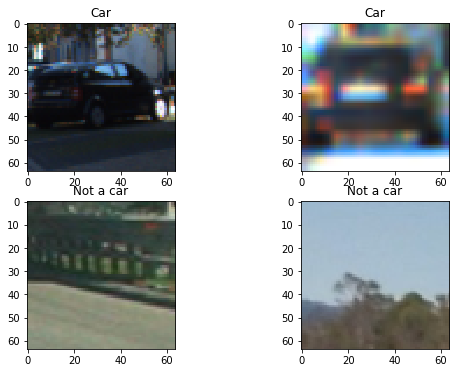

In [4]:
#randomly sampling and displaing 2 of car and non-car images each
display_images = []
captions = []
for i in np.random.random_integers(0, len(cars), 2):
    display_images.append(images[i])
    captions.append("Car")
for i in np.random.random_integers(len(cars), len(labels), 2):
    display_images.append(images[i])
    captions.append("Not a car")
display_images_in_2_colums(display_images, captions)

# print(images[0])

In [5]:
#splitting into training and test sests
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=rand_state)

print("1st Image pixel values are within {} .. {}".format(np.min(X_train[0]), np.max(X_train[0])))

1st Image pixel values are within 0.109803922474 .. 0.521568655968


In [152]:
#defining and training CNN
model = Sequential()

model.add(Lambda(lambda x: x - 0.5, input_shape=(64,64,3)))
model.add(Conv2D(9, 5, strides=(2,2)))
model.add(LeakyReLU(alpha=0.01))
model.add(Conv2D(27, 5))
model.add(LeakyReLU(alpha=0.01))
model.add(Conv2D(81, 5))
model.add(LeakyReLU(alpha=0.01))

model.add(SpatialDropout2D(0.3))

model.add(Flatten())

model.add(Dense(100))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(10))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [153]:
#Training
t = time.time()
model.fit(X_train, y_train, batch_size=128, epochs=25, validation_split=0.2, shuffle=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train CNN...')

# Check the score of the SVC
print('Loss, accuracy on Test set', model.evaluate(X_test, y_test))


Train on 11253 samples, validate on 2814 samples
Epoch 1/25
11253/11253 [==============================] - 2s - loss: 0.2646 - acc: 0.8787 - val_loss: 0.1085 - val_acc: 0.9581
Epoch 2/25
11253/11253 [==============================] - 1s - loss: 0.0966 - acc: 0.9647 - val_loss: 0.1770 - val_acc: 0.9389
Epoch 3/25
11253/11253 [==============================] - 1s - loss: 0.0846 - acc: 0.9711 - val_loss: 0.0586 - val_acc: 0.9783
Epoch 4/25
11253/11253 [==============================] - 1s - loss: 0.0421 - acc: 0.9859 - val_loss: 0.0465 - val_acc: 0.9844
Epoch 5/25
11253/11253 [==============================] - 1s - loss: 0.0319 - acc: 0.9898 - val_loss: 0.0526 - val_acc: 0.9819
Epoch 6/25
11253/11253 [==============================] - 1s - loss: 0.0394 - acc: 0.9848 - val_loss: 0.0761 - val_acc: 0.9790
Epoch 7/25
11253/11253 [==============================] - 1s - loss: 0.0266 - acc: 0.9908 - val_loss: 0.0450 - val_acc: 0.9883
Epoch 8/25
11253/11253 [==============================] - 1s -

In [21]:
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My CNN predicts: ', np.argmax(model.predict(X_test[0:n_predict]), axis=1))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with CNN')

('My CNN predicts: ', array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1]))
('For these', 10, 'labels: ', array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32))
(0.34504, 'Seconds to predict', 10, 'labels with CNN')


### Sliding window-based search for vehicles in a frame

In [296]:
# Single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, pattern_size=64, stride_pct=0.25, model=None, draw=False):

    draw_img = None
    if draw:
        draw_img = np.copy(img)        
    
    #scaling channels down to 0-1.0 range
    img = img.astype(np.float32)/255
    
    y_start, y_end = 400, 657
    imshape = (y_end - y_start, img.shape[1])
    
    samples = []
    corners = []
    
    #sliding window sizes to search vehicles within
    window_sizes=[80] #looks like 80 is the only one needed so far
#     for i in range(1,3):
#         window_sizes.append(pattern_size * i // 2)
    
#     print(window_sizes)
    
    for ws in window_sizes:
        step = np.int(ws * stride_pct)
        cols = np.int(np.ceil((imshape[1] - ws) / step) + 1)
        rows = np.int(np.ceil((imshape[0] - ws) / step) + 1)

        for row in range(rows):
            top = row * step + y_start
            bottom = top + ws
            for col in range(cols):
                left = col * step
                right = left + ws
                cut = img[top:bottom,left:right,:]
                #padding with zeros if needed
                sample = np.zeros((ws,ws,3))
                sample[0:cut.shape[0], 0:cut.shape[1], :] = cut
                #scaling down sample to pattern_size 
                if ws != pattern_size:
                    sample = cv2.resize(sample, (pattern_size, pattern_size))
                samples.append(sample)
                corners.append(((left, top),(right, bottom)))    

    samples = np.array(samples)
    corners = np.array(corners)
    #once samples are collected, doing prediction
    pred = np.argmax(model.predict(samples), axis=1)
    detections = corners[pred == 1]

    if draw:
        for box in detections:
            cv2.rectangle(draw_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0,0,255),6) 

#     print(detections.shape)
        
    return draw_img, detections
    
def add_heat(heatmap, detections):
    # Iterate through list of bboxes
    for box in detections:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

    

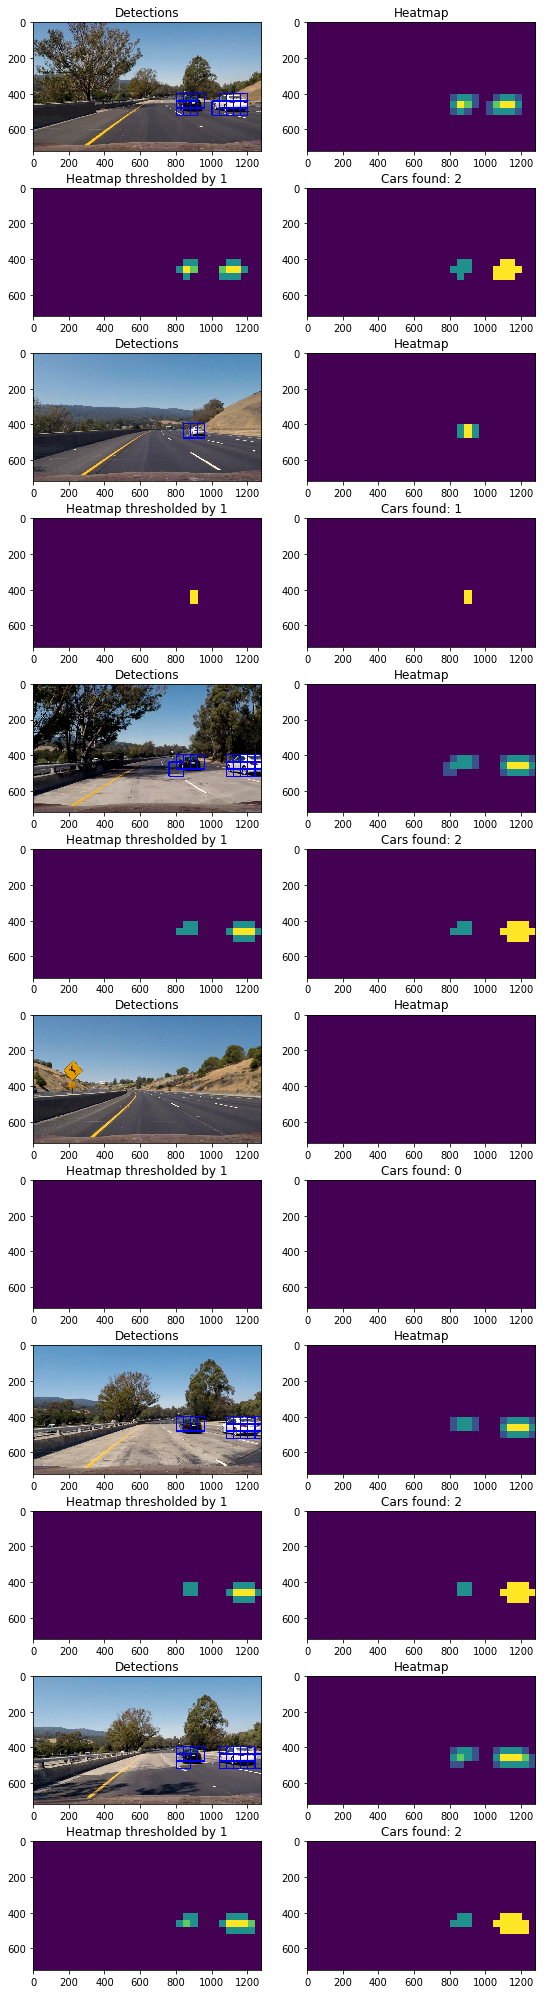

In [302]:
display_images = []
captions = []

for fl in glob.glob("./test_images/*.jpg"):
    img = mpimg.imread(fl)

    out_img, detections = find_cars(img, draw=True, model=model, stride_pct=0.5)
    display_images.append(out_img)
    captions.append("Detections")

    heatmap = np.zeros((img.shape[0], img.shape[1]))
    add_heat(heatmap, detections)        
    display_images.append(heatmap)
    captions.append("Heatmap")

    heatmap_thr = np.copy(heatmap)
    apply_threshold(heatmap_thr, 1)
    display_images.append(heatmap_thr)
    captions.append("Heatmap thresholded by 1")
    
    labeled = label(heatmap_thr)
    display_images.append(labeled[0])
    captions.append('Cars found: {}'.format(labeled[1]))

display_images_in_2_colums(display_images, captions)


### Video processing pipeline

In [283]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [298]:
HEATMAP_BUFFER_SIZE = 15
HEATMAP_THRESHOLD_PER_FRAME = 3
#buffer of last HEATMAP_BUFFER_SIZE frames
heatmaps = []

def draw_labeled_bboxes(img, labeled):
    # Iterate through all detected cars
    for car_number in range(1, labeled[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labeled[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#processes a video frame
def process_image(img):

    result = np.copy(img)
    
    #finding plausible car spots
    _, detections = find_cars(img, model=model)
    
    #building a heatmap
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    add_heat(heatmap, detections)        

    #adding heatmap to the buffer
    global heatmaps
    heatmaps.append(heatmap)
    if (len(heatmaps) > HEATMAP_BUFFER_SIZE):
        heatmaps = heatmaps[1:]
        
    #merging multiple heatmaps into one
    acc_hm = np.zeros_like(heatmaps[0])
    for hm in heatmaps:
        acc_hm += hm
    
    #applying threshold
    apply_threshold(acc_hm, HEATMAP_THRESHOLD_PER_FRAME * len(heatmaps))

    #counting number of pixel clusters
    labeled = label(acc_hm)
    draw_labeled_bboxes(result, labeled)
    caption = 'Cars found: {}'.format(labeled[1])
    cv2.putText(result, caption, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2)
    
    return result


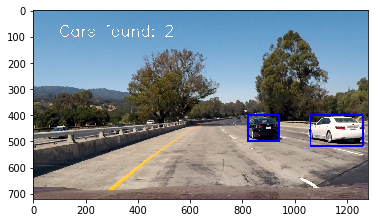

In [299]:
heatmaps = []
img = mpimg.imread("./test_images/test1.jpg")
img = process_image(img)
plt.imshow(img)
plt.show()

In [300]:
heatmaps = []
clip_output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")
clip_processing = clip.fl_image(process_image)
%time clip_processing.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



 97%|█████████▋| 38/39 [00:08<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 7.23 s, sys: 2.46 s, total: 9.69 s
Wall time: 9.62 s


In [301]:
heatmaps = []
clip_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
clip_processing = clip.fl_image(process_image)
%time clip_processing.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [04:57<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 4s, sys: 1min 21s, total: 5min 26s
Wall time: 4min 57s
